<h1><b>인공지능개론 7주차 과제<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Pytorch 분류(BP_data.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import(분류)</b></h2>

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# pytorch관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

<h2><b>1. 데이터 로딩</b></h2>

In [81]:
# URL
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/BP_data.csv"

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url)  # 이미 컬럼명이 포함된 경우는 header=0, 없으면 header=None + names=column_names

# 데이터 확인
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [82]:
# 컬렴명 확인
print(df.columns)

Index(['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [83]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: Pregnancy, Genetic_Pedigree_Coefficient, alcohol_consumption_per_day에서 결측치 발견

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64


In [84]:
# Pregnancy 제거
df.drop(columns=["Pregnancy"], inplace=True)
# Genetic_Pedigree_Coefficient, alcohol_consumption_per_day 평균값으로 대체
df['Genetic_Pedigree_Coefficient'] = df['Genetic_Pedigree_Coefficient'].fillna(df['Genetic_Pedigree_Coefficient'].mean())
df['alcohol_consumption_per_day'] = df['alcohol_consumption_per_day'].fillna(df['alcohol_consumption_per_day'].mean())

print(df.isna().sum())
#이상 모든 결측치 대체 완료

Patient_Number                   0
Blood_Pressure_Abnormality       0
Level_of_Hemoglobin              0
Genetic_Pedigree_Coefficient     0
Age                              0
BMI                              0
Sex                              0
Smoking                          0
Physical_activity                0
salt_content_in_the_diet         0
alcohol_consumption_per_day      0
Level_of_Stress                  0
Chronic_kidney_disease           0
Adrenal_and_thyroid_disorders    0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수(target)의 분포를 확인</li>

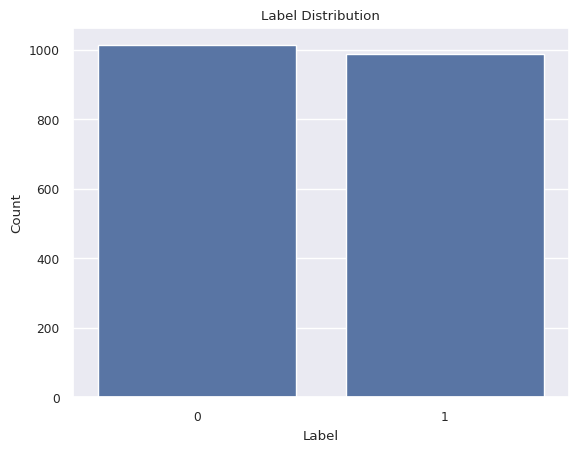

,count
Blood_Pressure_Abnormality,
0,1013
1,987


In [85]:
# 레이블 갯수 확인 (그래프)
sns.countplot(x='Blood_Pressure_Abnormality', data=df)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()

# 레이블 갯수 확인 (숫자)
df['Blood_Pressure_Abnormality'].value_counts()


<h2><b>4. 데이터 전처리</b></h2>

In [86]:
# 1. 타겟 분리
X = df.drop('Blood_Pressure_Abnormality', axis=1)
y = df['Blood_Pressure_Abnormality']

# 2. 범주형/수치형 컬럼 구분
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 3. LabelEncoder: 범주형 컬럼만 적용
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# 4. StandardScaler: 수치형 컬럼만 정규화
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 5. 출력 라벨 인코딩
output_encoder = LabelEncoder()
y = output_encoder.fit_transform(y)

# 6. 텐서 변환
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 7. 훈련/검증 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
)

# 8. DataLoader 생성
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)

# 9. 클래스 개수 확인
num_classes = len(output_encoder.classes_)


<h2><b>5. 모델 정의</b></h2>

In [87]:
class CarClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CarClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# 하이퍼파라미터 설정
input_dim = X.shape[1]
hidden_dim = 64
output_dim = num_classes

model = CarClassifier(input_dim, hidden_dim, output_dim)
summary(model, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             896
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                    [-1, 2]             130
Total params: 5,186
Trainable params: 5,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


<h2><b>6. 손실함수 및 옵티마이져 기법 정의</b></h2>

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2><b>7. 모델 학습 </b></h2>

In [89]:
epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 검증
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}%, Val Acc: {val_accuracies[-1]*100:.2f}%")


Epoch [1/50], Train Loss: 0.6661, Val Loss: 0.6145, Train Acc: 60.94%, Val Acc: 71.00%
Epoch [2/50], Train Loss: 0.5829, Val Loss: 0.5314, Train Acc: 71.31%, Val Acc: 73.25%
Epoch [3/50], Train Loss: 0.5440, Val Loss: 0.5122, Train Acc: 72.56%, Val Acc: 73.25%
Epoch [4/50], Train Loss: 0.5247, Val Loss: 0.4992, Train Acc: 74.62%, Val Acc: 76.25%
Epoch [5/50], Train Loss: 0.5097, Val Loss: 0.4807, Train Acc: 74.88%, Val Acc: 77.25%
Epoch [6/50], Train Loss: 0.4790, Val Loss: 0.4642, Train Acc: 78.00%, Val Acc: 79.00%
Epoch [7/50], Train Loss: 0.4615, Val Loss: 0.4442, Train Acc: 78.12%, Val Acc: 80.50%
Epoch [8/50], Train Loss: 0.4487, Val Loss: 0.4332, Train Acc: 79.31%, Val Acc: 80.00%
Epoch [9/50], Train Loss: 0.4244, Val Loss: 0.4166, Train Acc: 80.31%, Val Acc: 81.75%
Epoch [10/50], Train Loss: 0.4185, Val Loss: 0.3981, Train Acc: 80.06%, Val Acc: 84.25%
Epoch [11/50], Train Loss: 0.4082, Val Loss: 0.3874, Train Acc: 82.06%, Val Acc: 86.25%
Epoch [12/50], Train Loss: 0.3942, Val Lo

<h2><b>8. 학습곡선 시각화 </b></h2>

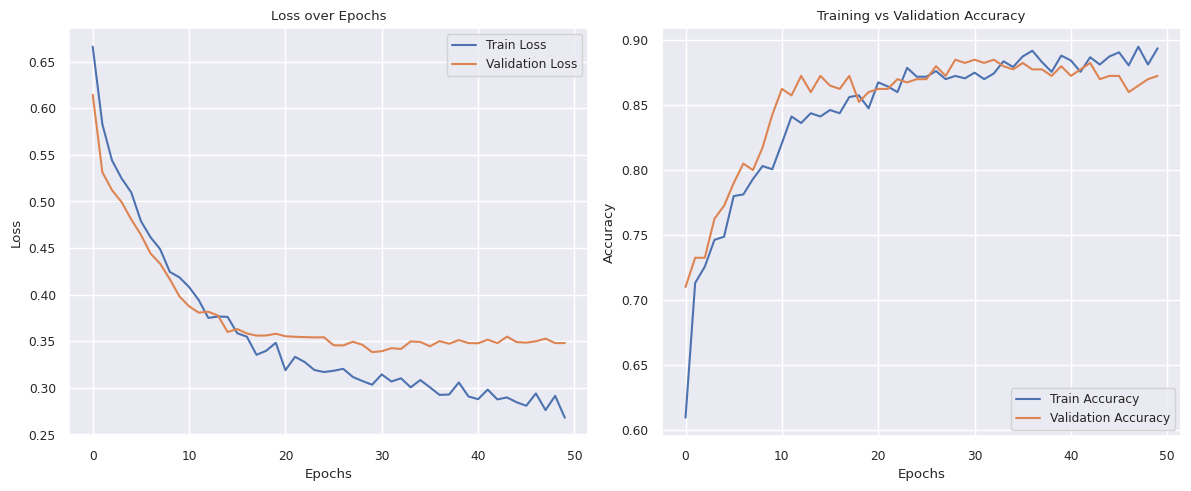

In [90]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<h2><b>9. 모델 평가 </b></h2>

Precision: 0.8725551746571916
Recall: 0.8725
F1 Score: 0.8724784734771979
ROC AUC Score: 0.8723587807256635


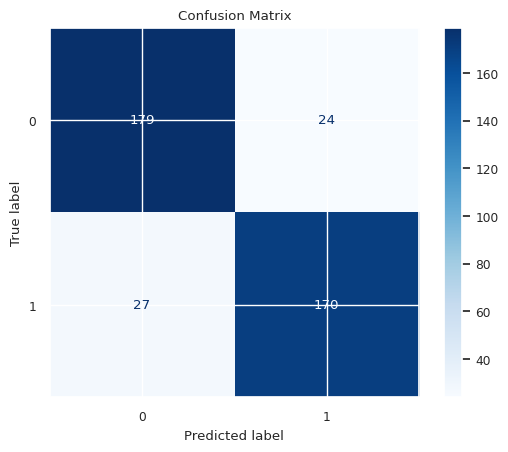

In [91]:
# 예측
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

# 평가 지표
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(pd.get_dummies(y_true), pd.get_dummies(y_pred), average='weighted', multi_class='ovr'))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=output_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


<h2><b>10. 데이터 시각화 </b></h2>

---



<h3><b>10-1 나이 분포 vs 혈압 이상 여부 </b></h3>

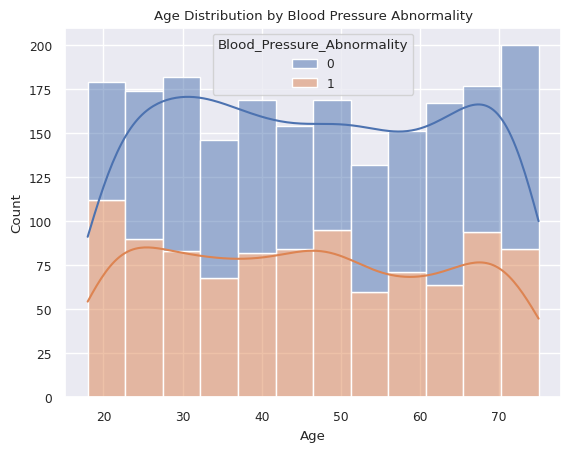

In [92]:
sns.histplot(data=df, x='Age', hue='Blood_Pressure_Abnormality', kde=True, multiple='stack')
plt.title("Age Distribution by Blood Pressure Abnormality")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

<h3><b>10-2 BMI 분포 vs 혈압 이상 여부 </b></h3>

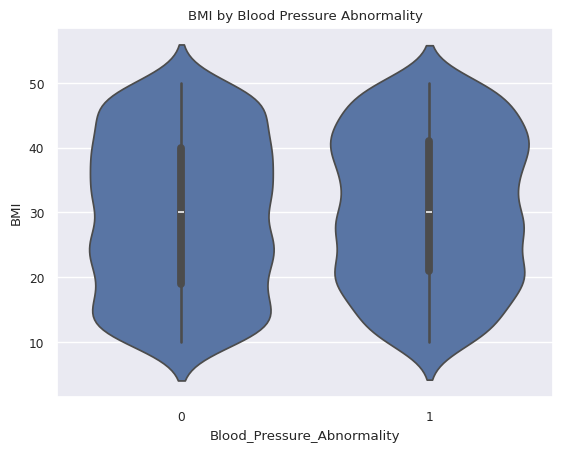

In [93]:
sns.violinplot(x='Blood_Pressure_Abnormality', y='BMI', data=df)
plt.title("BMI by Blood Pressure Abnormality")
plt.show()

<h3><b>10-3 하루 음주량 vs 혈압 이상 여부 </b></h3>

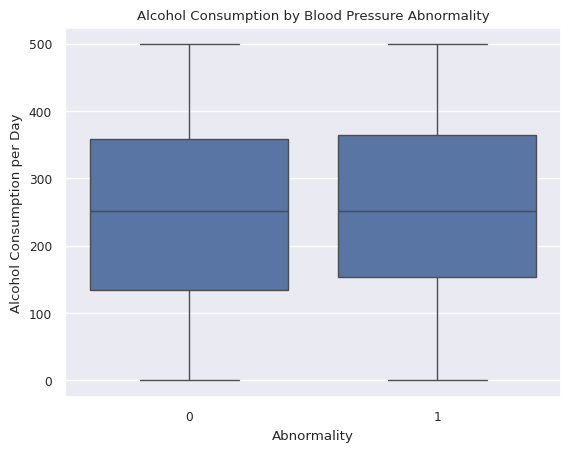

In [94]:
sns.boxplot(x='Blood_Pressure_Abnormality', y='alcohol_consumption_per_day', data=df)
plt.title("Alcohol Consumption by Blood Pressure Abnormality")
plt.xlabel("Abnormality")
plt.ylabel("Alcohol Consumption per Day")
plt.show()

<h3><b>10-4 성별 vs 혈압 이상 여부 </b></h3>

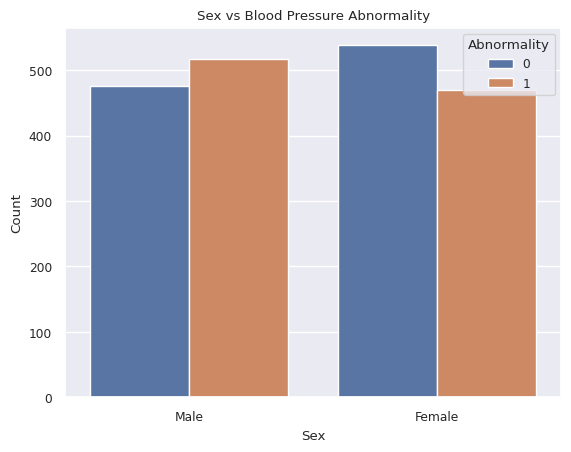

In [96]:
df['Sex'] = df['Sex'].map({0: 'Female', 1: 'Male'})

sns.countplot(x='Sex', hue='Blood_Pressure_Abnormality', data=df)
plt.title("Sex vs Blood Pressure Abnormality")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Abnormality")
plt.show()


<h3><b>10-5 상관관계 히트맵 </b></h3>

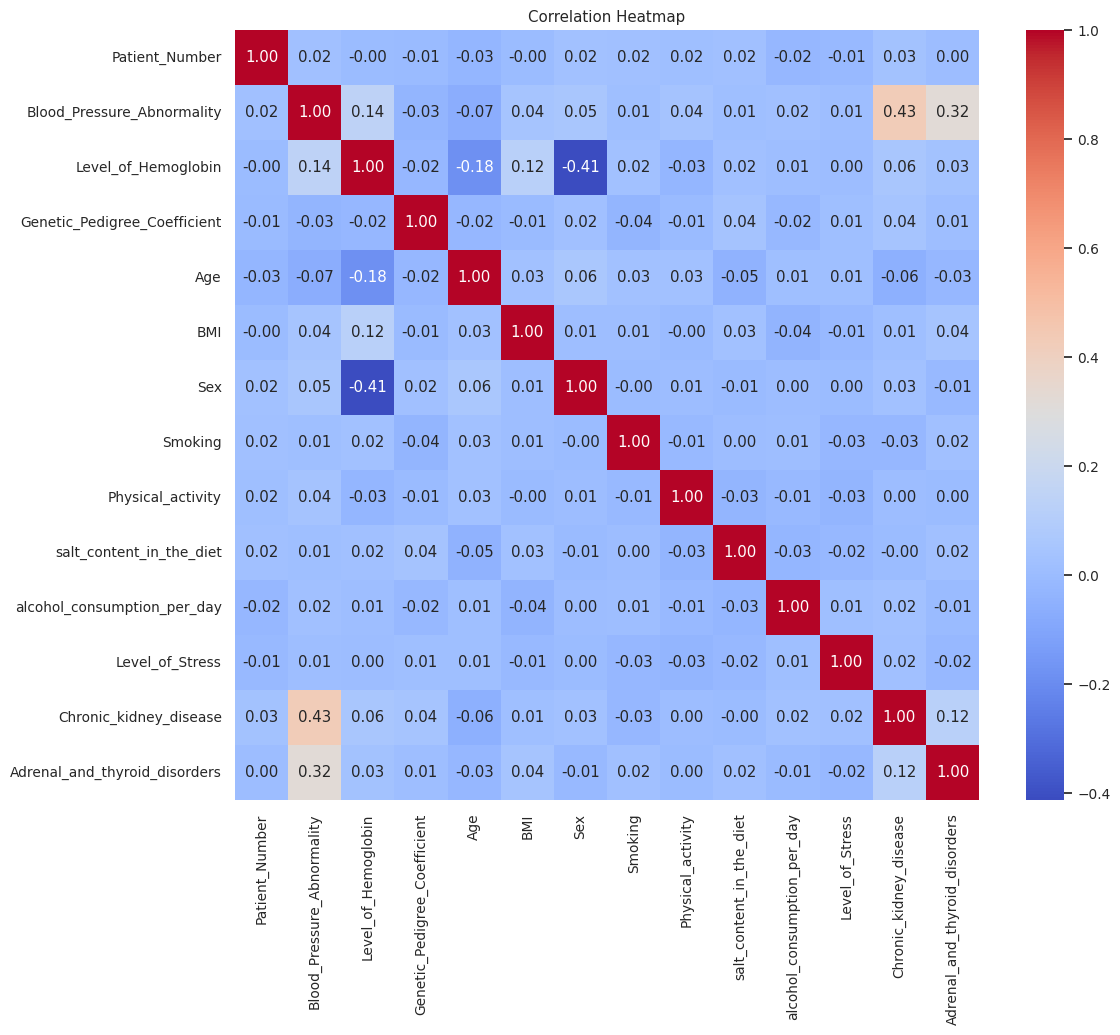

In [99]:
# 원본 df 복사
df_encoded = df.copy()

# 범주형 컬럼만 찾아서 인코딩
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# 상관계수 계산
df_corr = df_encoded.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.9)
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()

